In [145]:
!pip install ydf xgboost catboost

In [146]:
import kagglehub
import os
import pandas as pd
from geopy.geocoders import Nominatim
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import ydf
from ydf import RandomForestLearner, DecisionTreeLearner,GradientBoostedTreesLearner
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import pickle

In [147]:
path1 = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")

In [148]:
ds_path = [os.path.join(path1,p) for p in os.listdir(path1)]

In [149]:
print(ds_path[1])
df = pd.read_csv(ds_path[1])

/root/.cache/kagglehub/datasets/shubhambathwal/flight-price-prediction/versions/2/Clean_Dataset.csv


In [150]:
def get_lat_long(city_name):
    geolocator = Nominatim(user_agent="geoapi")
    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    else:
        return "City not found"

city = "Chennai"
latitude, longitude = get_lat_long(city)
print(f"Latitude: {latitude}, Longitude: {longitude}")

Latitude: 13.0836939, Longitude: 80.270186


In [151]:
cities = df['destination_city'].unique()
coordinates = {city:get_lat_long(city+",India") for city in cities}

In [152]:
df['source_longitude'] = df['source_city'].map(lambda x: coordinates[x][1] if x in coordinates else 0)
df['destination_longitude'] = df['destination_city'].map(lambda x: coordinates[x][1] if x in coordinates else 0)

df['source_latitude'] = df['source_city'].map(lambda x: coordinates[x][0] if x in coordinates else 0)
df['destination_latitude'] = df['destination_city'].map(lambda x: coordinates[x][0] if x in coordinates else 0)

In [153]:
df

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,source_longitude,destination_longitude,source_latitude,destination_latitude
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,77.171695,72.869203,28.627393,19.054999
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,77.171695,72.869203,28.627393,19.054999
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,77.171695,72.869203,28.627393,19.054999
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,77.171695,72.869203,28.627393,19.054999
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,77.171695,72.869203,28.627393,19.054999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265,80.270186,78.474061,13.083694,17.360589
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105,80.270186,78.474061,13.083694,17.360589
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099,80.270186,78.474061,13.083694,17.360589
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585,80.270186,78.474061,13.083694,17.360589


In [154]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of Earth (in kilometers)
    R = 6371
    distance = R * c
    return distance
lat1 =df['source_latitude'][0]
long1 =df['source_longitude'][0]
lat2 =df['destination_latitude'][0]
long2 =df['destination_longitude'][0]

In [155]:
df["Distance"] = df.apply(lambda row: haversine(row['source_latitude'], row['source_longitude'], row["destination_latitude"], row["destination_longitude"]), axis=1)

In [156]:
df.describe()

,Unnamed: 0,duration,days_left,price,source_longitude,destination_longitude,source_latitude,destination_latitude,Distance
count,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523,78.681761,78.850445,19.501952,19.388326,1173.018567
std,86646.852011,7.191997,13.561004,22697.767366,4.724566,4.802735,5.639990,5.559527,440.533089
min,0.000000,0.830000,1.000000,1105.000000,72.869203,72.869203,12.988157,12.988157,287.006476
25%,75038.000000,6.830000,15.000000,4783.000000,77.171695,77.171695,13.083694,13.083694,844.312460
50%,150076.000000,11.250000,26.000000,7425.000000,77.622600,77.622600,19.054999,19.054999,1184.427809
75%,225114.000000,16.170000,38.000000,42521.000000,80.270186,80.270186,22.572646,22.572646,1557.247591
max,300152.000000,49.830000,49.000000,123071.000000,88.363895,88.363895,28.627393,28.627393,1757.851156


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             300153 non-null  int64  
 1   airline                300153 non-null  object 
 2   flight                 300153 non-null  object 
 3   source_city            300153 non-null  object 
 4   departure_time         300153 non-null  object 
 5   stops                  300153 non-null  object 
 6   arrival_time           300153 non-null  object 
 7   destination_city       300153 non-null  object 
 8   class                  300153 non-null  object 
 9   duration               300153 non-null  float64
 10  days_left              300153 non-null  int64  
 11  price                  300153 non-null  int64  
 12  source_longitude       300153 non-null  float64
 13  destination_longitude  300153 non-null  float64
 14  source_latitude        300153 non-nu

In [158]:
df.isnull().sum()

,0
Unnamed: 0,0
airline,0
flight,0
source_city,0
departure_time,0
stops,0
arrival_time,0
destination_city,0
class,0
duration,0


In [159]:
cols_to_keep = ['airline','departure_time','stops','arrival_time','class','price', 'source_longitude', 'destination_longitude',
                'source_latitude', 'destination_latitude', 'Distance']
new_df = df[cols_to_keep]

In [160]:
cols_to_encode = ['airline','departure_time','stops','arrival_time','class']
new_df[cols_to_encode]

,airline,departure_time,stops,arrival_time,class
0,SpiceJet,Evening,zero,Night,Economy
1,SpiceJet,Early_Morning,zero,Morning,Economy
2,AirAsia,Early_Morning,zero,Early_Morning,Economy
3,Vistara,Morning,zero,Afternoon,Economy
4,Vistara,Morning,zero,Morning,Economy
...,...,...,...,...,...
300148,Vistara,Morning,one,Evening,Business
300149,Vistara,Afternoon,one,Night,Business
300150,Vistara,Early_Morning,one,Night,Business
300151,Vistara,Early_Morning,one,Evening,Business


array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'source_longitude'}>],
       [<Axes: title={'center': 'destination_longitude'}>,
        <Axes: title={'center': 'source_latitude'}>],
       [<Axes: title={'center': 'destination_latitude'}>,
        <Axes: title={'center': 'Distance'}>]], dtype=object)

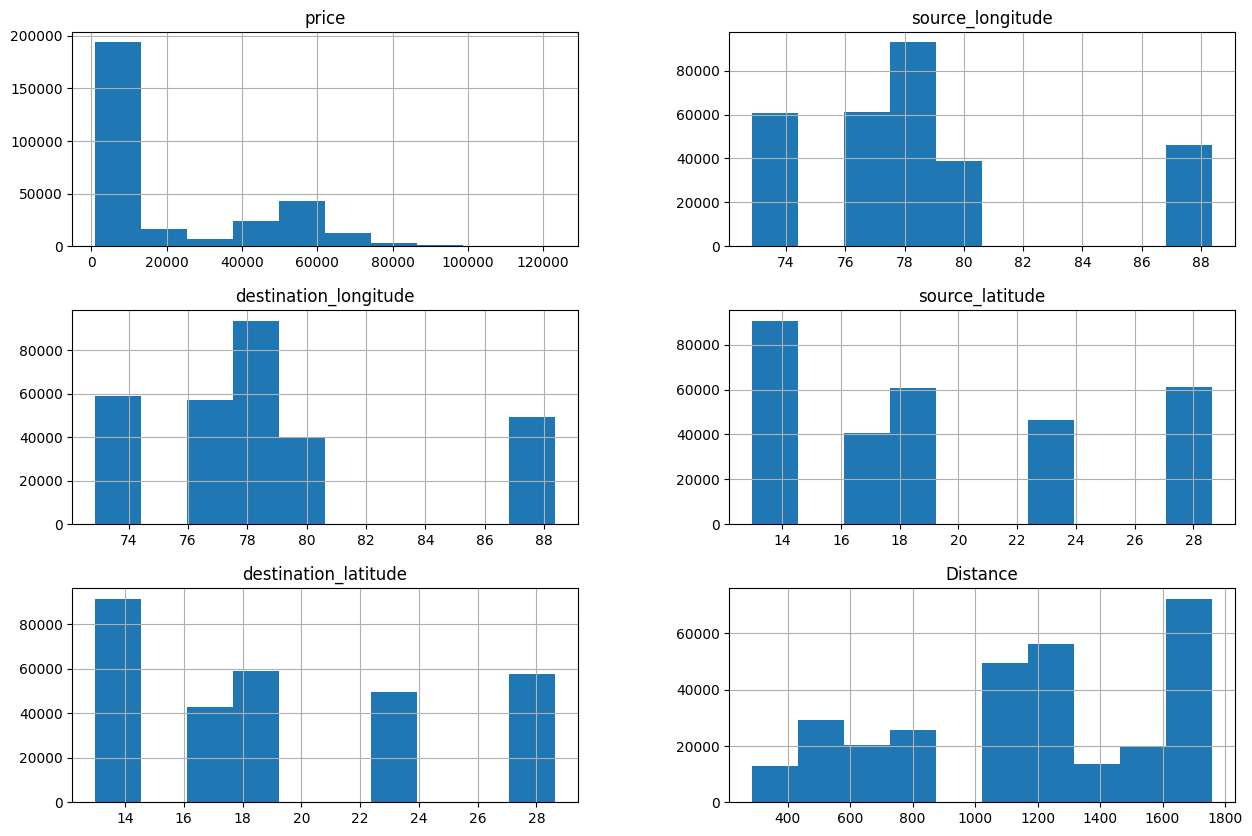

In [161]:
new_df.hist(figsize=(15,10))

In [162]:
train_df,test_df = train_test_split(new_df,test_size=0.1,random_state=42)

In [176]:
test = {'airline': ['SpiceJet'],'departure_time': ['Evening'],'stops': ['zero'],'arrival_time': ['Night'],'class': ['Economy'],'source_longitude': [77.1716954],'destination_longitude': [72.8692035],
 'source_latitude': [28.6273928],'destination_latitude': [19.054999],'Distance': [1150.5283183803408]}


In [164]:
model1 = ydf.RandomForestLearner(label="price",
                                task=ydf.Task.REGRESSION).train(train_df)
evaluation = model1.evaluate(test_df)
print(evaluation)
model1.predict(test)

Train model on 270137 examples
Model trained in 0:02:08.323288
RMSE: 4578.81
num examples: 30016
num examples (weighted): 30016



array([3757.782], dtype=float32)

In [165]:
pred1 = model1.predict(test_df.drop('price',axis=1))
r2_1 = r2_score(test_df['price'],pred1)
r2_1

0.9592870473861694

In [167]:
model2 = ydf.GradientBoostedTreesLearner(label="price",
                                task=ydf.Task.REGRESSION).train(train_df)
evaluation = model2.evaluate(test_df)
print(evaluation)

Train model on 270137 examples
Model trained in 0:00:49.035921
RMSE: 4769.95
num examples: 30016
num examples (weighted): 30016



In [168]:
pred2 = model2.predict(test_df.drop('price',axis=1))
r2_2 = r2_score(test_df['price'],pred2)
print(r2_2)
model2.predict(test)

0.9558169841766357


array([3586.5076], dtype=float32)

In [169]:
model3 = ydf.DecisionTreeLearner(label="price",task=ydf.Task.REGRESSION).train(train_df)
evaluation = model3.evaluate(test_df)
print(evaluation)

Train model on 270137 examples
Model trained in 0:00:00.709881
RMSE: 4642.95
num examples: 30016
num examples (weighted): 30016



In [170]:
pred3 = model3.predict(test_df.drop('price',axis=1))
r2_3 = r2_score(test_df['price'],pred3)
print(r2_3)
model3.predict(test)

0.9581384658813477


array([3661.5803], dtype=float32)

In [171]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
# Encode categorical columns in the train and test datasets
for col in cols_to_encode:
    encoder = LabelEncoder()
    train_df[col] = encoder.fit_transform(train_df[col])
    test_df[col] = encoder.transform(test_df[col])
    encoders[col] = encoder

In [172]:
X_train, y_train = train_df.drop('price', axis=1), train_df['price']
X_test, y_test = test_df.drop('price', axis=1), test_df['price']

In [173]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
pred4 = xgb.predict(X_test)

In [177]:
for i in cols_to_encode:
  test[i] = encoders[i].transform(test[i])
test = pd.DataFrame(test)

In [179]:
r2_4 = r2_score(y_test,pred4)
print(r2_4)
xgb.predict(test)

0.9572539925575256


array([3896.191], dtype=float32)

In [180]:
cbm = CatBoostRegressor()
cbm.fit(X_train,y_train,verbose=0)
pred5 = cbm.predict(X_test)

In [181]:
r2_5 = r2_score(y_test,pred5)
print(r2_5)
cbm.predict(test)

0.9573749294406133


array([3993.51805985])

In [182]:
lgb = LGBMRegressor()
lgb.fit(X_train,y_train)
pred6 = lgb.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 270137, number of used features: 10
[LightGBM] [Info] Start training from score 20893.986022


In [183]:
r2_6 = r2_score(y_test,pred6)
print(r2_6)
lgb.predict(test)

0.9549037882145746


array([3947.4617365])

In [195]:
scores = [r2_1,r2_2,r2_3,r2_4,r2_5,r2_6]
scores = [round(x,4) for x in scores]

array([11980.55417954])